In [331]:
# Miscellaneous
from functools import partial 
from ticktack import load_presaved_model

# Hamiltonian monte-carlo
from numpyro.infer import NUTS, MCMC

import jax.numpy as np
import jax.scipy as sc
import jax.random as random
import jax.lax as lax
import matplotlib.pyplot as plt
from jax import jit, jacrev, jacfwd, vmap, grad

In [332]:
cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()

In [343]:
def construct_model(cbm=cbm):
    template = np.where(cbm._matrix != 0, np.ones(cbm._matrix.shape), np.zeros(cbm._matrix.shape))
    indexes = np.where(cbm._matrix != 0)
    indexes = np.array(indexes).T

    @jit
    def scan_fun(template, parameter_and_index):
        param, [i, j] = parameter_and_index
        template = template.at[i, j].set(param)
        return template, template

    @jit
    def parse_parameters(parameters, indexes=indexes, template=template, scan_fun=scan_fun):
        params_and_indexes = [parameters, indexes]
        model, _ = lax.scan(scan_fun, template, params_and_indexes)
        return model

    return parse_parameters

In [344]:
@partial(jit, static_argnums=(0))
def load(filename: str):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        header = next(data)
        data = np.array([row.strip().split(" ") for row in data], dtype=np.float64)
        return data.T


In [345]:
parse_parameters = construct_model(cbm)
parameters = random.uniform(random.PRNGKey(1), (35, 1))

In [346]:
@jit
def analytic_solution(parameters, time_out, /, decay=cbm._decay_matrix, parser=parse_parameters):
    """
    This is the analytic solution itself.
    Parameters: 
        
    Returns:
    """
    start_date = parameters[0]
    event_area = parameters[1]
    production = parameters[2]
    production = np.array([1 - production, production, *np.zeros(9)], dtype=np.float64)
    flow_sizes = parameters[3:]

    initial_position = event_area * production

    # Consider moving this into less lines and profiling
    transfer_matrix = parser(flow_sizes)
    transfer_matrix -= transfer_matrix.T
    transfer_matrix /= 2
    transfer_matrix -= np.diag(np.sum(transfer_matrix, axis=1))
    transfer_matrix -= decay

    @vmap
    def vmap_util(t, /, transfer_matrix=transfer_matrix, y0=initial_position, start=start_date):
        return sc.linalg.expm((t - start) * transfer_matrix) @ y0

    impulse_solution = vmap_util(time_out)
    steady_solution = np.zeros((impulse_solution.shape))
    condition = (time_out > start_date).reshape(-1, 1)
    
    return np.where(condition, impulse_solution, steady_solution)

In [347]:
data = load("miyake12.csv")
data = data.at[1].add(-np.mean(data[1, 1:4]))

In [348]:
@partial(jit, static_argnums=(1, 2))
def loss(parameters, /, analytic_solution=analytic_solution, data=data):
    """
    Computes the log likelihood of a set of parameters in the parameter space
    """
    # in_bounds = 0.0
    # in_bounds = np.any((parameters[2:] < 0.0) | (parameters[2:] > 1.0)) * np.inf
    analytic_data = analytic_solution(parameters, data[0])
    chi_sq = np.sum((data[1] - analytic_data[:, 1]) ** 2 / data[2] ** 2)
    return chi_sq

In [349]:
param_init = np.array([774.8, 40.0, 0.3], dtype=np.float64).reshape(3, 1)
parameters = np.concatenate([param_init, parameters]).reshape(-1)

In [354]:
gradient = jit(grad(loss))
hessian = jit(jacfwd(jacrev(loss)))

In [353]:
%%timeit
loss(parameters)

610 µs ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [357]:
%%timeit
gradient(parameters)

2.77 ms ± 90.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [361]:
%%timeit
hessian(parameters)

186 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [362]:
# Running the No U Turn sampling
nuts_kernel = NUTS(potential_fn=loss)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=500, progress_bar=True)
mcmc.run(random.PRNGKey(11), init_params=parameters)

sample: 100%|██████████| 600/600 [24:17<00:00,  2.43s/it, 1023 steps of size 1.14e-03. acc. prob=0.85]


In [363]:
test = mcmc.get_samples()

In [364]:
import seaborn as sns
sns.set()

IndexError: index 2 is out of bounds for axis 0 with size 2

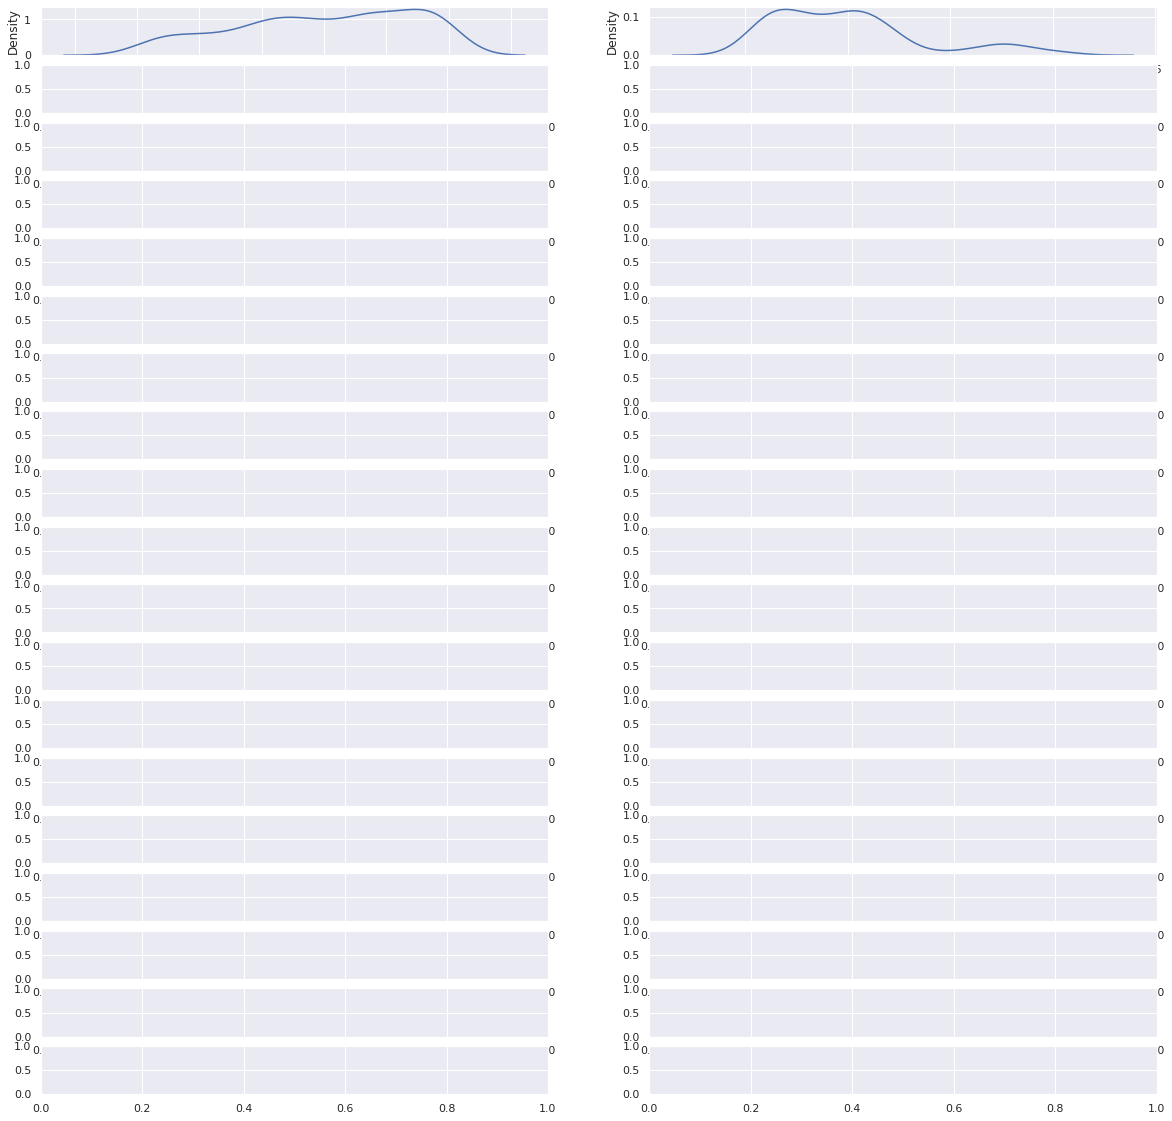

In [369]:
fig, axes = plt.subplots(19, 2, figsize=(20, 190))
for index, variable in enumerate(test.T):
    axis = axes[index // 2][index % 19]
    sns.kdeplot(test.T[index], ax=axis)